# DH-CH Enricher

TODO: scope of the notebook

## Import data

In [3]:
import os
import requests
from urllib.parse import urlsplit
import tarfile
from pathlib import Path

zenodo_url = "https://zenodo.org/records/14887484/files/dh-ch.tar"

def download_and_extract(url, path):
    tar_name = urlsplit(url).path.split('/')[-1] # dh-ch.tar
    tar_path = os.path.join(path, tar_name) # data/raw/dh-ch.tar
    untarred_folder = tar_name.split('.')[0] # dh-ch
    untarred_path = os.path.join(path, untarred_folder) # data/raw/dh-ch
    if not os.path.exists(untarred_path):
        if not os.path.exists(tar_path):
            print(f"downloading ${url}")
            try:
                with requests.get(url, stream=True) as response:
                    response.raise_for_status()
                    with open(tar_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
            except requests.exceptions.RequestException as e:
                print("Error downloading the file:", e)

        print(f"untar ${tar_name}")
        with tarfile.open(tar_path, "r") as tar:
            tar.extractall(path)

        print('cleaning')
        os.remove(tar_path)


# Download data into /data/raw
download_and_extract(zenodo_url, "/app/openaire/data/raw")

downloading $https://zenodo.org/record/10837214/files/datasource.tar
untar $datasource.tar
cleaning


## Import libraries

In [4]:
import json

import glob
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StructType
from pyspark.sql import SparkSession
from IPython.display import JSON as pretty_print

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## Load the datasets

In [35]:
ls -l /app/openaire/data/raw/

total 88
drwxr-xr-x 2 openaire openaire 86016 Feb 23 18:57 dh-ch/


### Load one part to get an overview of the content

In [8]:
df = pd.read_json('data/raw/dh-ch/part-00000-d943311f-ebab-47e3-ad2d-fd9b3a958372-c000.json.gz', compression='gzip', lines=True)
df.head(2)

,authors,bestAccessRight,collectedFrom,communities,contributors,countries,coverages,dateOfCollection,descriptions,formats,id,indicators,instances,isGreen,isInDiamondJournal,language,lastUpdateTimeStamp,mainTitle,originalIds,pids,publicationDate,publiclyFunded,publisher,sources,subjects,type,organizations,container,openAccessColor,projects,subTitle,embargoEndDate
0,"[{'fullName': 'Societat Arqueològica Lul·liana', 'rank': 1}]","{'code': 'c_abf2', 'label': 'OPEN', 'scheme': 'http://vocabularies.coar-repositories.org/documen...","[{'key': 'openaire____::4cb2a3eb94033446c37331f60fad0847', 'value': 'Recolector de Ciencia Abier...","[{'code': 'gotriple', 'label': 'GOTRIPLE - Social Sciences and Humanities Discovery service', 'p...",[],[],[],2024-12-18T16:22:18.926,[],[application/pdf],RECOLECTA___::63ca8c3155ba473a631f765a38459182,"{'citationImpact': {'citationClass': 'C5', 'citationCount': 0.0, 'impulse': 0.0, 'impulseClass':...","[{'accessRight': {'code': 'c_abf2', 'label': 'OPEN', 'scheme': 'http://vocabularies.coar-reposit...",1.0,0.0,"{'code': 'und', 'label': 'Undetermined'}",1.733523e+12,Bolletí de la Societat Arqueològica Lul·liana,[oai:dnet:bibliotecadi::48cb3cc31dc516f2c5561d483e3bf908],[],1894-01-01,0.0,Societat Arqueològica Lul·liana (Palma),"[reponame:Biblioteca Digital de les Illes Balears, instname:Universidad de las Islas Baleares]","[{'provenance': {'provenance': 'Harvested', 'trust': '0.9'}, 'subject': {'scheme': 'keyword', 'v...",publication,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'fullName': 'Segura Tinoco, German Andrés', 'name': 'German Andrés', 'rank': 1, 'surname': 'S...","{'code': 'c_abf2', 'label': 'OPEN', 'scheme': 'http://vocabularies.coar-repositories.org/documen...","[{'key': 'openaire____::4cb2a3eb94033446c37331f60fad0847', 'value': 'Recolector de Ciencia Abier...","[{'code': 'dh-ch', 'label': 'Digital Humanities and Cultural Heritage', 'provenance': [{'provena...",[UAM. Departamento de Ingeniería Informática],[],[],2024-12-18T16:22:23.692,"[In the recommender systems literature, it has been shown that, in addition to improving system ...",[application/pdf],RECOLECTA___::64d3f9d3761aaee4a713ab647e2cae3c,"{'citationImpact': {'citationClass': 'C5', 'citationCount': 0.0, 'impulse': 0.0, 'impulseClass':...","[{'accessRight': {'code': 'c_abf2', 'label': 'OPEN', 'scheme': 'http://vocabularies.coar-reposit...",1.0,0.0,"{'code': 'Inglés', 'label': 'Inglés'}",1.733520e+12,Argument-based generation and explanation of recommendations,[oai:repositorio.uam.es:10486/705253],"[{'scheme': 'handle', 'value': '10486/705253'}]",2021-01-01,0.0,Association for Computing Machinery (ACM),"[reponame:Biblos-e Archivo. Repositorio Institucional de la UAM, instname:Universidad Autónoma d...","[{'provenance': {'provenance': 'Harvested', 'trust': '0.9'}, 'subject': {'scheme': 'keyword', 'v...",publication,NaN,NaN,NaN,NaN,NaN,NaN


### Let's load the whole data with Spark

First thing first, let's create the Spark session.

In [17]:
spark = SparkSession.builder.getOrCreate()

In [37]:
inputPath = '/app/openaire/data/raw/dh-ch/'
dhch_results = spark.read.json(inputPath)
dhch_results.printSchema()

[Stage 11:====================================================>   (33 + 2) / 35]

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- fullName: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- pid: struct (nullable = true)
 |    |    |    |-- id: struct (nullable = true)
 |    |    |    |    |-- scheme: string (nullable = true)
 |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- provenance: struct (nullable = true)
 |    |    |    |    |-- provenance: string (nullable = true)
 |    |    |    |    |-- trust: string (nullable = true)
 |    |    |-- rank: long (nullable = true)
 |    |    |-- surname: string (nullable = true)
 |-- bestAccessRight: struct (nullable = true)
 |    |-- code: string (nullable = true)
 |    |-- label: string (nullable = true)
 |    |-- scheme: string (nullable = true)
 |-- collectedFrom: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: str

Let's create some `Temporary views`, which is similar to a real SQL table that you can query via Spark.

In [38]:
dhch_results.createOrReplaceTempView("dhch_results")

Ok, let's count the number of rows.

In [39]:
print("number of dhch results %s"%dhch_results.count())

[Stage 12:===================================================>    (32 + 3) / 35]

number of dhch results 1696330


By the way, the same could be achieved in SQL via Spark.

In [40]:
spark.sql("SELECT COUNT(*) FROM dhch_results").toPandas()

,count(1)
0,1696330


Let's show some data now. 
For example, a publication

In [42]:
pretty_print(json.loads(dhch_results
                        .where("id='RECOLECTA___::64d3f9d3761aaee4a713ab647e2cae3c'")
                        .toJSON()
                        .first()), expanded=False)

<IPython.core.display.JSON object>

Or a dataset

In [43]:
pretty_print(json.loads(dhch_results
                        .where("id='r3f52792889d::9e185c70f4f9aad9f6b7753d06485cff'")
                        .toJSON()
                        .first()), expanded=False)

<IPython.core.display.JSON object>

Or simply, the first record

In [44]:
pretty_print(json.loads(dhch_results.toJSON().first()), expanded=False)

<IPython.core.display.JSON object>

## Exercises 

All the exercises follow the template below.
```python
query = """
SELECT <columns>
FROM <table>
"""

spark.sql(query).limit(20).toPandas()
```

`toPandas()` results in the collection of all records in the PySpark DataFrame to the driver program and should be done only on a small subset of the data. running on larger dataset’s results in memory error and crashes the application.
`limit(20)` is added exactly for this purpose.

<div class="alert alert-info">
Show information about publishing venues.
</div>

In [45]:
query = """
SELECT container.issnLinking, container.issnOnline, container.issnPrinted, container.name 
FROM dhch_results 
WHERE container IS NOT NULL
"""

spark.sql(query).limit(20).toPandas()

,issnLinking,issnOnline,issnPrinted,name
0,,,0036-6978,"NTM Zeitschrift für Geschichte der Wissenschaften, Technik und Medizin"
1,,,2251-7871,Journal of Nanostructures
2,,,1519-311X,Galáxia
3,,,0514-7336,Zephyrus
4,,,2605-4450,"Santander, Estudios de Patrimonio"
5,,,1410-9700,Gelar: Jurnal Seni Budaya
6,,,0213-0181,Gerión
7,,,0215-773X,TEFLIN Journal
8,,,1405-6313,La Colmena
9,,,1408-967X,Documenta Praehistorica


<div class="alert alert-info">
Count and sort publications by citations.
</div>

In [46]:
query = """
SELECT count(res.id) as num_results, res.indicators.citationImpact.citationCount as citationCount
FROM dhch_results res 
GROUP BY res.indicators.citationImpact.citationCount
ORDER BY res.indicators.citationImpact.citationCount DESC
"""

spark.sql(query).limit(20).toPandas()

,num_results,citationCount
0,1,21523.0
1,1,7254.0
2,1,5560.0
3,1,5151.0
4,1,3588.0
5,1,3485.0
6,1,3333.0
7,1,3233.0
8,1,2939.0
9,1,2848.0


Now let's order by number of results

In [47]:
query = """
SELECT count(res.id) as num_results, res.indicators.citationImpact.citationCount as citationCount
FROM dhch_results res 
GROUP BY res.indicators.citationImpact.citationCount
ORDER BY num_results DESC
"""

spark.sql(query).limit(20).toPandas()

,num_results,citationCount
0,1526570,0.0
1,43628,NaN
2,37620,1.0
3,17144,2.0
4,10656,3.0
5,7321,4.0
6,5460,5.0
7,4280,6.0
8,3325,7.0
9,2906,8.0


<div class="alert alert-info">
Show the most occurring publication subjects; sort results in descending order; limit to the first 20.
</div>

In [49]:
query = """
WITH terms AS (
    SELECT explode(subjects.subject.value) AS `term`
    FROM dhch_results res
    WHERE res.type='publication'
)
SELECT term AS `subject term`,
        COUNT(*) AS count 
FROM terms 
GROUP BY term 
ORDER BY count DESC
"""

spark.sql(query).limit(20).toPandas()

,subject term,count
0,Archaeology,218552
1,History,161156
2,Language and Literature,120449
3,P,120304
4,Grey Literature,87721
5,Digital Humanities,62582
6,605007 Digital Humanities,57500
7,Humanities,49888
8,Arts and Humanities,46109
9,Fine Arts,43551


<div class="alert alert-info">
Show the journals with the highest number of publications
</div>

In [51]:
query = """
WITH journals AS (
    SELECT container.*
    FROM dhch_results 
    WHERE container IS NOT NULL AND type='publication'
)
SELECT name, count(*) AS count 
FROM journals 
GROUP BY name 
ORDER BY count DESC
"""

spark.sql(query).limit(20).toPandas()

,name,count
0,Nueva Revista de Filología Hispánica (NRFH),3327
1,Kalbotyra,2201
2,مجلة ابحاث كلية التربية الاساسية,1963
3,مجلة الآداب,1906
4,Akofena,1887
5,"Journal of Architecture, Art & Humanistic Science",1838
6,Al-Adab Journal,1779
7,Kufa Journal of Arts,1755
8,Travessias,1695
9,Historia Mathematica,1625


<div class="alert alert-info">
Show projects with the highest number of associated results. 

Note: An `unidentified` project title is a placeholder for all the associations to a funder without knowing the specific project. It should be removed from the count.
</div>

In [56]:
query = """
SELECT project.funder.shortName, project.code, project.title, COUNT(*) AS count 
FROM dhch_results LATERAL VIEW EXPLODE(projects) p as project 
WHERE project.code is not null AND
project.code <> 'unidentified'
GROUP BY project.funder.shortName, project.code, project.title
ORDER BY count DESC
"""

spark.sql(query).limit(20).toPandas()

,shortName,code,title,count
0,EC,823782,Social Sciences & Humanities Open Cloud,911
1,EC,654119,"Pooling Activities, Resources and Tools for Heritage E-research Networking, Optimization and Syn...",599
2,EC,675680,"Building Research environments for fostering Innovation, Decision making, Governance and Educati...",460
3,EC,654024,SoBigData Research Infrastructure,457
4,EC,654142,Engaging the EGI Community towards an Open Science Commons,457
5,EC,654182,Environmental Research Infrastructures Providing Shared Solutions for Science and Society,457
6,EC,283465,Common Operations of Environmental Research Infrastructures,456
7,EC,283644,Data e-Infrastructure Initiative for Fisheries Management and Conservation of Marine Living Reso...,456
8,EC,239019,Data Infrastructure Ecosystem for Science,456
9,EC,288754,EU-Brazil Open Data and Cloud Computing e-Infrastructure for Biodiversity,456


<div class="alert alert-info">
Show the most co-occurring publication subjects from controlled vocabularies (i.e., scheme != 'keyword') avoiding repetition; limit to the first 20.
</div>

In [58]:
query = """
WITH subjects AS (
    WITH exploded_subjects (
        SELECT id, EXPLODE(subjects.subject) AS subject 
        FROM dhch_results WHERE type='publication') 
    SELECT id, subject.value AS `subject` 
    FROM exploded_subjects 
    WHERE subject.scheme != 'keyword'  
)
SELECT l.subject AS left, 
       r.subject AS right, 
       COUNT(*) AS count
FROM subjects AS l JOIN subjects AS r ON l.id = r.id AND l.subject < r.subject
GROUP BY left, right
ORDER BY count DESC
"""

spark.sql(query).limit(20).toPandas()

,left,right,count
0,06 humanities and the arts,0601 history and archaeology,24005
1,01 natural sciences,0105 earth and related environmental sciences,21467
2,03 medical and health sciences,0302 clinical medicine,18734
3,06 humanities and the arts,0602 languages and literature,13784
4,05 social sciences,06 humanities and the arts,12887
5,05 social sciences,0501 psychology and cognitive sciences,12325
6,02 engineering and technology,"0202 electrical engineering, electronic engineering, information engineering",12140
7,03 medical and health sciences,0301 basic medicine,10421
8,01 natural sciences,06 humanities and the arts,9692
9,01 natural sciences,0601 history and archaeology,9259


<div class="alert alert-info">
Show the number of research products per organization; sort results in descending order; limit to the first 20. 
</div>

In [60]:
query = """
SELECT organization.legalname, COUNT(*) AS count 
FROM dhch_results LATERAL VIEW EXPLODE(organizations) o as organization 
GROUP BY organization
ORDER BY count DESC
"""

spark.sql(query).limit(20).toPandas()

,legalname,count
0,University of Oxford,25633
1,Université Paris Diderot,15986
2,Florida Southern College,7894
3,University of California System,7528
4,Utrecht University,6453
5,Leiden University,5919
6,University of Liège,5892
7,Vrije Universiteit Amsterdam,5605
8,University of Groningen,5342
9,Uppsala University,5108


<div class="alert alert-info">
Show the number of research products (per type) per organization.
</div>

In [61]:
query = """
SELECT  organization.legalname, 
       COUNT(*) AS total,
       COUNT(IF(type = 'publication', 1, NULL)) AS publication,
       COUNT(IF(type = 'dataset', 1, NULL)) AS dataset,
       COUNT(IF(type = 'software', 1, NULL)) AS software,
       COUNT(IF(type = 'other', 1, NULL)) AS other
FROM dhch_results LATERAL VIEW EXPLODE(organizations) o as organization 
GROUP BY organization 
ORDER BY total DESC
"""

spark.sql(query).limit(20).toPandas()

,legalname,total,publication,dataset,software,other
0,University of Oxford,25633,2509,6691,1,16432
1,Université Paris Diderot,15986,12954,0,1,3031
2,Florida Southern College,7894,7883,10,0,1
3,University of California System,7528,5053,92,0,2383
4,Utrecht University,6453,1471,4935,19,28
5,Leiden University,5919,945,4929,2,43
6,University of Liège,5892,237,3,0,5652
7,Vrije Universiteit Amsterdam,5605,635,4946,2,22
8,University of Groningen,5342,405,4931,1,5
9,Uppsala University,5108,1359,117,0,3632


<div class="alert alert-info">
Show result access types per organization.
</div>

In [62]:
query = """
SELECT  organization.legalname, 
       COUNT(*) as total,
       COUNT(IF(bestaccessright.label = 'OPEN', 1, NULL)) AS open,
       COUNT(IF(bestaccessright.label = 'EMBARGO', 1, NULL)) AS embargo,
       COUNT(IF(bestaccessright.label = 'CLOSED', 1, NULL)) AS closed
FROM dhch_results LATERAL VIEW EXPLODE(organizations) o as organization 
GROUP BY organization
ORDER BY total DESC
"""

spark.sql(query).limit(20).toPandas()

,legalname,total,open,embargo,closed
0,University of Oxford,25633,2414,62,73
1,Université Paris Diderot,15986,10044,1,630
2,Florida Southern College,7894,1441,0,81
3,University of California System,7528,4596,0,53
4,Utrecht University,6453,4616,17,188
5,Leiden University,5919,4252,2,86
6,University of Liège,5892,345,0,11
7,Vrije Universiteit Amsterdam,5605,3890,3,103
8,University of Groningen,5342,3709,1,38
9,Uppsala University,5108,4993,1,12


<div class="alert alert-info">
Show the result access types per country.
</div>

In [64]:
query = """
SELECT country.code AS country, 
       COUNT(*) AS total,
       COUNT(IF(bestaccessright.label = 'OPEN', 1, NULL)) AS open,
       COUNT(IF(bestaccessright.label = 'EMBARGO', 1, NULL)) AS embargo,
       COUNT(IF(bestaccessright.label = 'CLOSED', 1, NULL)) AS closed
FROM dhch_results LATERAL VIEW EXPLODE(countries) c as country 
GROUP BY country.code
ORDER BY total DESC
"""

spark.sql(query).limit(20).toPandas()

,country,total,open,embargo,closed
0,DE,102285,101503,2,188
1,US,41255,20210,0,1040
2,ES,28593,27566,21,57
3,FR,22392,14777,1,830
4,IT,16396,12791,6,1829
5,CA,15298,12729,8,368
6,SE,12856,12846,1,0
7,GB,12736,10754,106,934
8,BE,12477,3492,55,2640
9,NL,11779,8697,29,1018


Results can be modeled as a graph and analysed. Let's try doing so with igraph and feed it with country couples and the number of coaffiliated results

Show the collaboration network of countries 

In [68]:
query = """
WITH countryResult AS (
    SELECT country.code AS country, id 
    FROM dhch_results LATERAL VIEW EXPLODE(countries) c as country
    WHERE country IS NOT NULL
)
SELECT l.country AS left, 
       r.country AS right,
       COUNT(*) AS count 
FROM countryResult AS l JOIN countryResult AS r ON l.id = r.id AND l.country != r.country
GROUP BY left, right 
ORDER BY count DESC
"""

edges = spark.sql(query).toPandas()
edges

,left,right,count
0,FR,IT,1336
1,IT,FR,1336
2,FR,GB,946
3,GB,FR,946
4,IT,GB,825
...,...,...,...
1607,CH,SA,1
1608,NL,MT,1
1609,SG,HR,1
1610,AR,LU,1


In [69]:
import igraph as ig

G = ig.Graph.TupleList(
    edges=edges[['left', 'right', 'count']].values,
    vertex_name_attr='countrycode',
    edge_attrs = ['weight'],
    directed=False)

Let's find the number of nodes in the graph.

In [70]:
G.vcount()

77

Now, let's find the number of edges.

In [71]:
G.ecount()

1612

A generic node can be inspected like so

In [72]:
G.vs[0]

igraph.Vertex(<igraph.Graph object at 0xffff60f7be50>, 0, {'countrycode': 'FR'})

Instead, a generic edge can be inspected with

In [73]:
G.es[0]

igraph.Edge(<igraph.Graph object at 0xffff60f7be50>, 0, {'weight': 1336})

Ok. Let's try to plot something. The whole network looks like this.

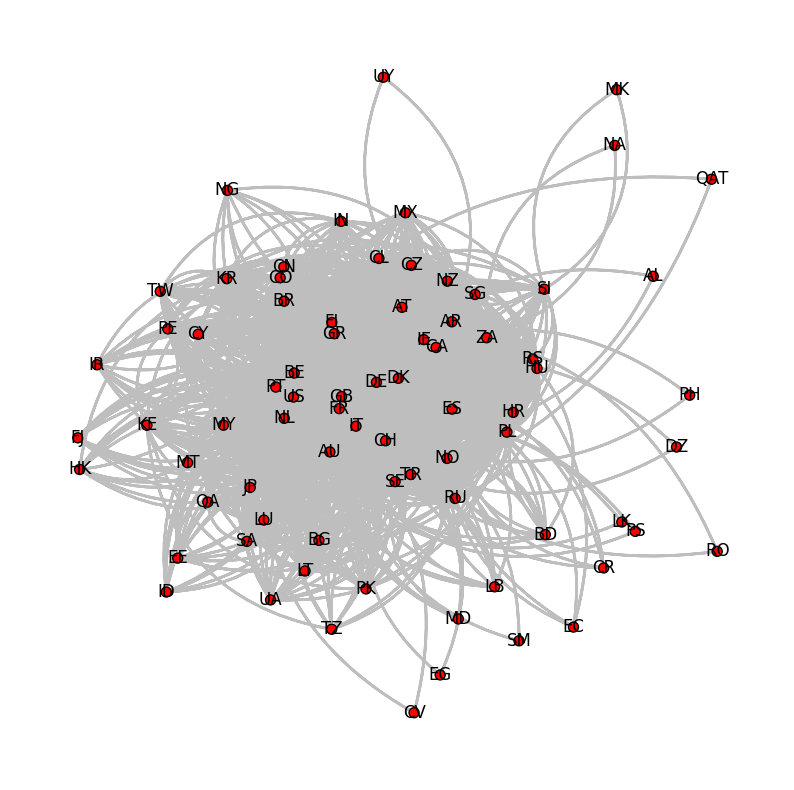

In [113]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
max_w = np.max(G.es['weight'])
ig.plot(G, vertex_label=G.vs['countrycode'], vertex_size=10, edge_width=2, edge_color='gray', target=ax)

Now, let's filter by country, say Italy (i.e., IT)

In [137]:
itnode = G.vs.find(countrycode_eq = 'IT')
itnode_idx = itnode.index
H = G.induced_subgraph(G.neighborhood(itnode))
H.summary()

'IGRAPH U-W- 56 1468 -- \n+ attr: countrycode (v), weight (e)'

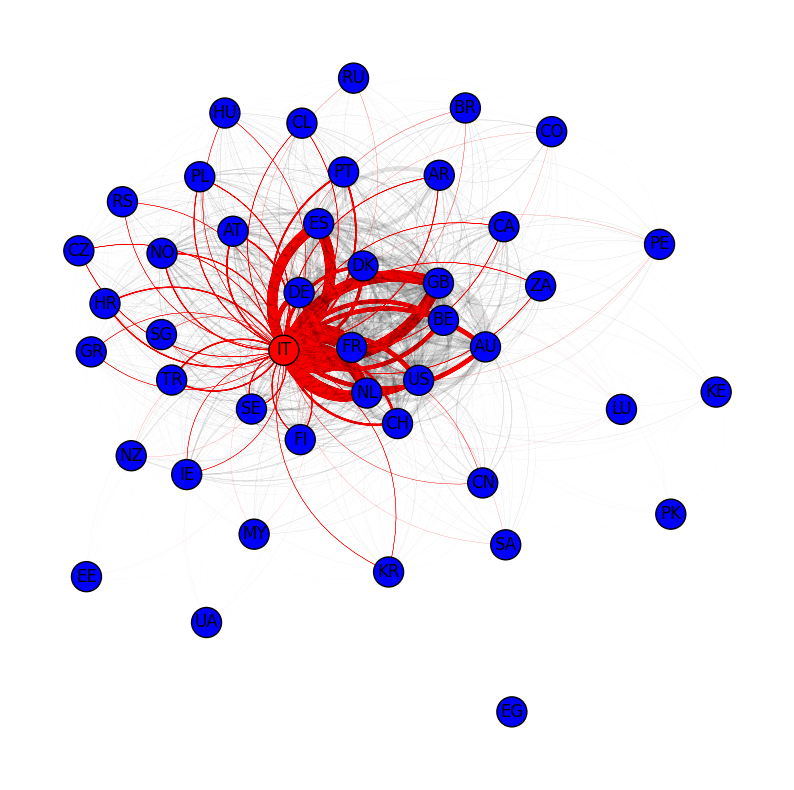

In [154]:
H.vs['color'] = 'blue'
H.vs.find(countrycode_eq = 'IT')['color'] = 'red'
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(H, vertex_label=H.vs['countrycode'], vertex_size=30, edge_width=[weight/100 for weight in H.es["weight"]], edge_color=['red' if (edge.target == itnode_idx or edge.source == itnode_idx) else 'rgba(1,1,1,0.1)' for edge in H.es],target=ax)